## Wordembedding

In [2]:
import json
import random
import statistics
from pathlib import Path
from collections import defaultdict
import os
import glob

import syntok.segmenter as segmenter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings
from scipy import spatial
from scipy.ndimage.filters import gaussian_filter1d

import ipywidgets
from ipywidgets import IntProgress

import matplotlib.pyplot as plt

### alle Sätze auswählen die Emotionen beinhalten

In [3]:
emotion = ['liebreich','angst', 'ängstlich', 'trauer', 'traurig', 'zornig', 'zorn', 'verachtungsvoll', 'verachtung',
           'schuld', 'schuldig', 'liebe',  'geliebt', 'liebevoll', 'stolz', 'scham', 'schämen', 'überrasschung',
           'überrascht', 'sorge', 'sorgenvoll', 'ekel', 'ekeln', 'angeekelt', 'neid', 'neidisch', 'neidvoll',
           'glücklich', 'glück', 'freude', 'freudig', 'freuen', 'erleichterung', 'erleichtert', 'vergnügt', 'vergnügen',
           'zufrieden', 'zufriedenheit', 'verzweiflung', 'verzweifelt', 'verlegenheit', 'verlegen', 'aufregung',
           'aufgeregt', 'aufregen', 'spannung', 'gespannt', 'erregung', 'erregt', 'hoffen', 'hoffnung', 'befriedigt',
           'langweilig', 'langeweile', 'mitgefühl', 'mitfühlen', 'enttäuscht', 'enttäuschung', 'frust', 'frustriert',
           'eifersucht', 'eifersüchtig', 'wut', 'wütend', 'reue', 'schock', 'schockiert', 'zuneigung', 'verärgert',
           'verärgerung', 'erwartungsvoll', 'erwartung', 'vorfreude', 'scheu', 'gelassen', 'gelassenheit', 'mut',
           'mutig', 'neugierde', 'neugierig', 'depression', 'depressiv', 'niedergeschlagenheit', 'niedergeschlagen',
           'lustvoll', 'lust', 'rausch', 'einfühlend', 'einfühlsam', 'euphorisch', 'euphorie', 'dankbarkeit', 'dankbar',
           'hass', 'entsetzt', 'entsetzen', 'demütigung', 'demütig', 'demut', 'interesse', 'interessiert', 'einsamkeit',
           'einsam', 'empörung', 'empört', 'vertrauen', 'qualvoll', 'qual', 'gleichgültigkeit', 'gleichgültig',
           'fröhlichkeit', 'fröhlich', 'schadenfroh', 'schadenfreude', 'schmerz', 'melancholie', 'melancholisch',
           'panik', 'panisch']

sentences = []

inpath = '/home/piah/Dokumente/Uni/Projektarbeit/Projektarbeit_LyrikGattungszuweisung/corpus/corpus/gesamt/'

for text in os.listdir(inpath):
    if text.endswith('.txt'):
        f_lemma = []
        result = ''
        t = open(inpath + '/' + text, 'r')
        f = t.read()


for files in f:
    for paragraph in segmenter.process(f):
        for sentence in paragraph:
            tokens = [str(token).strip() for token in sentence]
            for emo in emotion:
                if emo in tokens:
                    index = tokens.index(emo)
                    sentences.append({"sentence": tokens, "index": index, "source":file, "emotion": emotion})
print(sentence)

[<Token '' : 'um' @ 0>, <Token ' ' : 'bei' @ 3>, <Token ' ' : 'du' @ 7>, <Token ' ' : 'zu' @ 10>, <Token ' ' : 'sein' @ 13>, <Token '   ' : 'trügen' @ 20>, <Token ' ' : 'ich' @ 27>, <Token ' ' : 'not' @ 31>, <Token ' ' : 'und' @ 35>, <Token ' ' : 'fährde' @ 39>, <Token '   ' : 'lassen' @ 48>, <Token ' ' : 'ich' @ 55>, <Token ' ' : 'freund' @ 59>, <Token ' ' : 'und' @ 66>, <Token ' ' : 'haus' @ 70>, <Token ' ' : 'und' @ 75>, <Token ' ' : 'die' @ 79>, <Token ' ' : 'fülle' @ 83>, <Token ' ' : 'die' @ 89>, <Token ' ' : 'erde' @ 93>, <Token '   ' : 'ich' @ 100>, <Token ' ' : 'verlangen' @ 104>, <Token ' ' : 'nach' @ 114>, <Token ' ' : 'du' @ 119>, <Token '   ' : 'wie' @ 124>, <Token ' ' : 'die' @ 128>, <Token ' ' : 'flut' @ 132>, <Token ' ' : 'nach' @ 137>, <Token ' ' : 'die' @ 142>, <Token ' ' : 'strand' @ 146>, <Token '   ' : 'wie' @ 155>, <Token ' ' : 'die' @ 159>, <Token ' ' : 'schwalbe' @ 163>, <Token ' ' : 'in+die' @ 172>, <Token ' ' : 'herbst' @ 179>, <Token ' ' : 'nach' @ 186>, <Tok

## Wortvektoren generieren

In [4]:
embedding = TransformerWordEmbeddings("redewiedergabe/bert-base-historical-german-rw-cased")

In [5]:
for example in sentences:
    text = " ".join(example["sentence"])
    sentence = Sentence(text, use_tokenizer=False)
    embedding.embed(sentence)
    
    token = sentence[example["index"]]
    example["vector"] = [float(dim) for dim in token.embedding]

## Positive und negative Wortumgebung

In [7]:
words = {}

with open("/home/piah/Dokumente/Uni/Projektarbeit/Projektarbeit_LyrikGattungszuweisung/scripts/wordembedding/Wortlisten/Positiv.txt", "r", encoding="utf-8") as f:
    words["positiv"] = random.sample([f"Die Emotion ist {word}" for word in f.read().split("\n")], 500)
    
with open("/home/piah/Dokumente/Uni/Projektarbeit/Projektarbeit_LyrikGattungszuweisung/scripts/wordembedding/Wortlisten/Negativ.txt", "r", encoding="utf-8") as f:
    words["negativ"] = random.sample([f"Die Emotion ist {word}" for word in f.read().split("\n")], 500)
    
print(f"Positive Worte: {len(words['positiv'])}")
print(f"Negative Worte: {len(words['negativ'])}")

Positive Worte: 500
Negative Worte: 500


In [8]:
positive = []
negative = []

for word in words["positiv"]:
    sentence = Sentence(word, use_tokenizer=False)
    embedding.embed(sentence)

    token = sentence[2]
    positive.append([float(dim) for dim in token.embedding])

for word in words["negativ"]:
    sentence = Sentence(word, use_tokenizer=False)
    embedding.embed(sentence)

    token = sentence[2]
    negative.append([float(dim) for dim in token.embedding])

## Ähnlichkeiten

In [9]:
for sentence in sentences:
    positive_scores = []
    negative_scores = []

    for vector in positive:
        positive_scores.append(1 - spatial.distance.cosine(sentence["vector"], vector))
    for vector in negative:
        negative_scores.append(1 - spatial.distance.cosine(sentence["vector"], vector))
    
    sentence["positive_mean"] = statistics.mean(positive_scores)
    sentence["negative_mean"] = statistics.mean(negative_scores)
    sentence["absolute_difference"] = abs(sentence["positive_mean"] - sentence["negative_mean"])

# Visualisierung

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score

### Read corpora

In [3]:
data = [{"class": "Ballade", "text": file.read_text()} for file in Path("Balladen").glob("*.txt")]
data.extend([{"class": "Lied", "text": file.read_text()} for file in Path("Lieder").glob("*.txt")])

### Load document embedding

In [4]:
embedding = TransformerDocumentEmbeddings("redewiedergabe/bert-base-historical-german-rw-cased")

### Get document embeddings

In [5]:
vectors = []
labels = []

for document in data:
    sentence = Sentence(document["text"])
    embedding.embed(sentence)
    vectors.append(sentence.embedding.tolist())
    labels.append(document["class"])
    
vectors = np.array(vectors)

### Visualize with PCA

In [6]:
pca = PCA(n_components=2)
components = pca.fit_transform(vectors)

<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

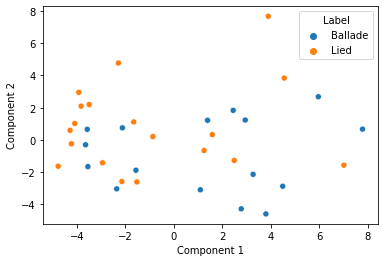

In [7]:
df = pd.DataFrame(components)
df["Label"] = labels
df.columns = ["Component 1", "Component 2", "Label"]
sns.scatterplot(x="Component 1", y="Component 2", data=df, hue="Label")

### Visualize with t-SNE

In [8]:
tsne = TSNE(n_components=2, random_state=0)
embedded = tsne.fit_transform(vectors)

<AxesSubplot:xlabel='Dimension 1', ylabel='Dimension 2'>

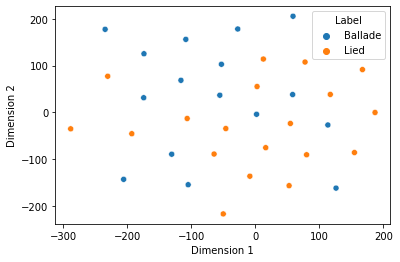

In [9]:
df = pd.DataFrame(embedded)
df["Label"] = labels
df.columns = ["Dimension 1", "Dimension 2", "Label"]
sns.scatterplot(x="Dimension 1", y="Dimension 2", data=df, hue="Label")

### k-Means clustering

In [10]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(vectors)

KMeans(n_clusters=2, random_state=0)

In [11]:
adjusted_rand_score(labels, kmeans.labels_)

0.07182582745523611